In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install pyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.0 MB/s eta 0:00:00a 0:00:01m


In [27]:
!pip install tensorflow==2.15.0     #2.15.0 te kaaj kre    
# !pip install --upgrade tensorflow

In [26]:
from os import listdir
import plotly.express as px
from matplotlib.image import imread
from tensorflow.keras.utils import to_categorical


import glob
import PIL
import random

random.seed(100)

from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Lambda, SeparableConv2D, GlobalAvgPool2D, Input, Average, ReLU, Dropout, DepthwiseConv2D, Dense, GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU



from keras.preprocessing import image

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import pandas as pd
# from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

from datetime import datetime
from keras.callbacks import ModelCheckpoint

# import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow.keras.preprocessing'

In [6]:
breast_imgs = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [7]:
for imgname in breast_imgs[:5]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png


In [8]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [9]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer 
        
total_img_num = non_cancer_num + cancer_num
        
print('Number of Images of no cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(cancer_num))   # images of cancer 
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


In [10]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})

In [11]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

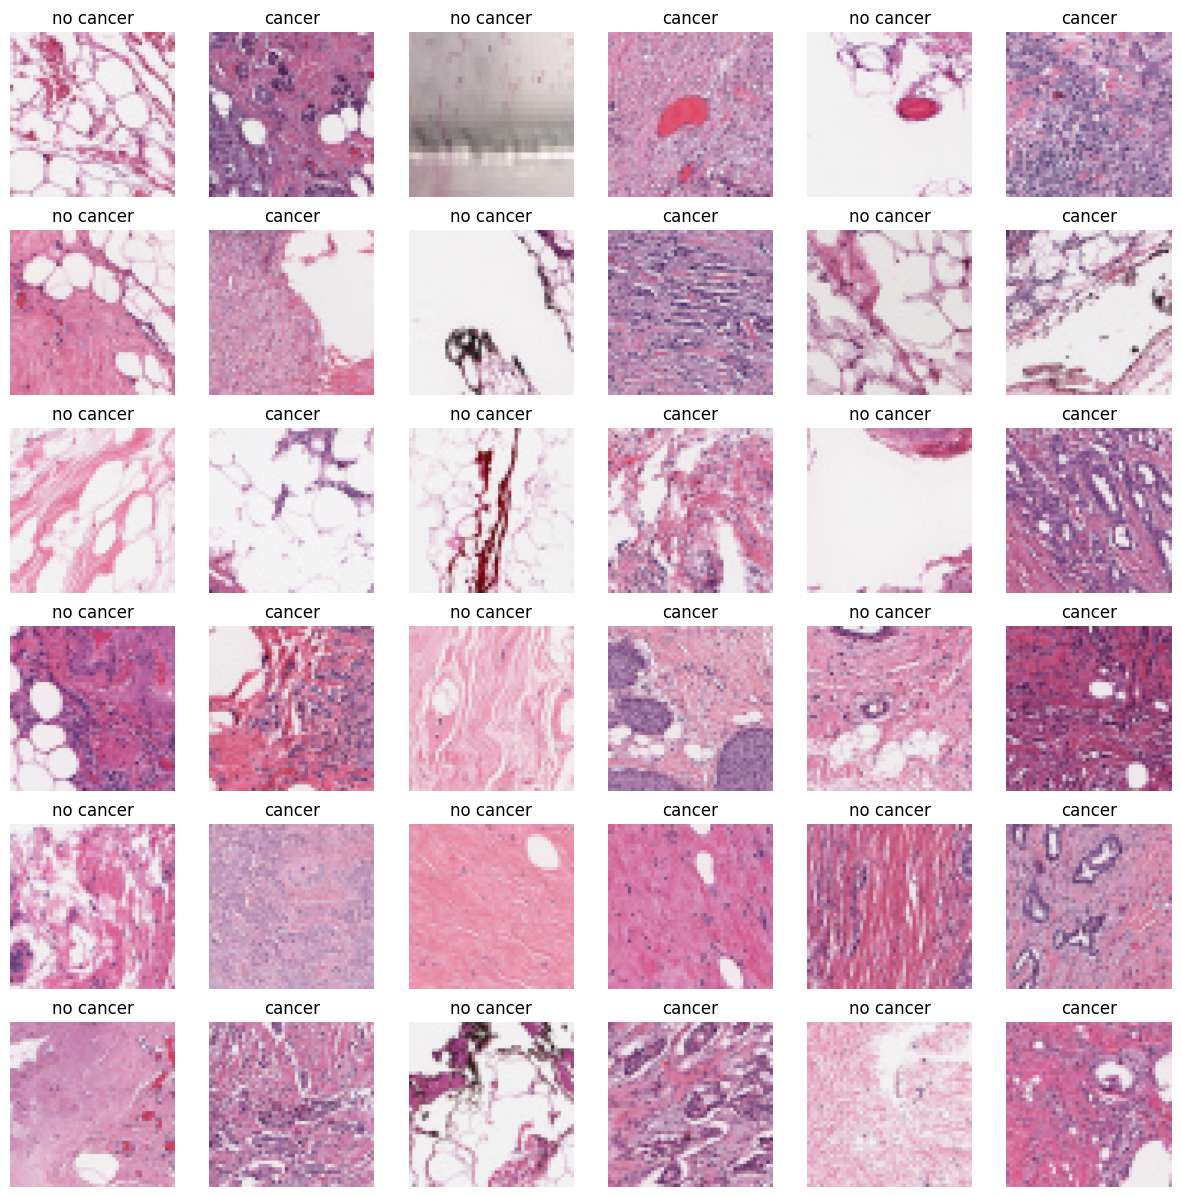

In [12]:
plt.figure(figsize=(15, 15))

some_non = np.random.randint(0, len(non_cancer_imgs), 18)
some_can = np.random.randint(0, len(cancer_imgs), 18)

s = 0
for num in some_non:
    img = image.load_img(non_cancer_imgs[num], target_size=(100, 100))
    img = image.img_to_array(img)

    plt.subplot(6, 6, 2 * s + 1)
    plt.axis('off')
    plt.title('no cancer')
    plt.imshow(img.astype('uint8'))
    s += 1

s = 0  # Reset s to 0 for the cancer images
for num in some_can:
    img = image.load_img(cancer_imgs[num], target_size=(100, 100))
    img = image.img_to_array(img)

    plt.subplot(6, 6, 2 * s + 2)
    plt.axis('off')
    plt.title('cancer')
    plt.imshow(img.astype('uint8'))
    s += 1

plt.show()


In [13]:
from tqdm import tqdm

# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'
some_non_img = random.sample(non_cancer_imgs, 5000)
some_can_img = random.sample(cancer_imgs, 5000)

# Initialize empty arrays to store image data and labels
non_img_arr = []  # Array for non-cancer images
can_img_arr = []  # Array for cancer images

# Loop through each image in the 'some_non_img' list
for img in tqdm(some_non_img):
    # Read the image in color mode
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'
    non_img_arr.append([n_img_size, 0])

# Loop through each image in the 'some_can_img' list
for img in tqdm(some_can_img):
    # Read the image in color mode
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 1 (indicating cancer) to the 'can_img_arr'
    can_img_arr.append([c_img_size, 1])

100%|██████████| 5000/5000 [00:37<00:00, 134.73it/s]


[[[115  60 125]
  [157 107 171]
  [ 97  38  88]
  ...
  [ 99  38  92]
  [113  61 111]
  [ 85  37  86]]

 [[159 103 180]
  [173 134 177]
  [ 94  44  89]
  ...
  [141  88 144]
  [117  79 122]
  [130  80 134]]

 [[165 117 183]
  [181 139 199]
  [107  57 100]
  ...
  [ 93  41  88]
  [115  60 116]
  [165 118 177]]

 ...

 [[135  78 139]
  [132  76 146]
  [155 110 191]
  ...
  [159 111 184]
  [157 102 167]
  [130  79 144]]

 [[155 108 155]
  [135  83 154]
  [164 118 174]
  ...
  [178 136 197]
  [164 119 190]
  [149  98 192]]

 [[118  64 128]
  [170 128 189]
  [ 88  42  87]
  ...
  [168 124 182]
  [167 124 180]
  [170 132 190]]]


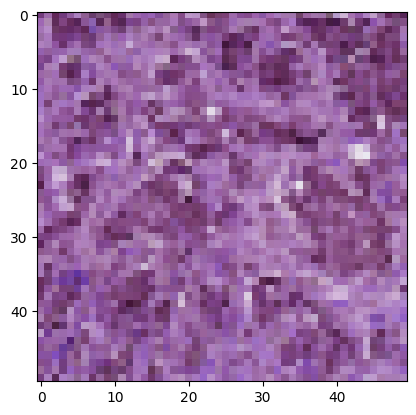

In [14]:
len(can_img_arr), len(non_img_arr)
plt.imshow(can_img_arr[0][0])
print(can_img_arr[0][0])

In [15]:
X = []  # List for image data
y = []  # List for labels

# Concatenate the arrays 'non_img_arr' and 'can_img_arr' into a single array 'breast_img_arr'
breast_img_arr = non_img_arr + can_img_arr

# Shuffle the elements in the 'breast_img_arr' array randomly
random.shuffle(breast_img_arr)

# Loop through each element (feature, label) in the shuffled 'breast_img_arr'
for feature, label in breast_img_arr:
    # Append the image data (feature) to the 'X' list
    X.append(feature)
    # Append the label to the 'y' list
    y.append(label)

# Convert the lists 'X' and 'y' into NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the 'X' array
print('X shape: {}'.format(X.shape))

X shape: (10000, 50, 50, 3)


In [16]:
# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define a rate (percentage) for subsampling the training data
rate = 0.5

# Calculate the number of samples to keep in the training data based on the rate
num = int(X.shape[0] * rate)

# Convert the categorical labels in 'y_train' and 'y_test' to one-hot encoded format
y_train = to_categorical(y_train, 2)  # Assuming there are 2 classes (non-cancer and cancer)
y_test = to_categorical(y_test, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (8000, 50, 50, 3)
X_test shape : (2000, 50, 50, 3)
y_train shape : (8000, 2)
y_test shape : (2000, 2)


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators for training and testing
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
test_datagen = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# # Data augmentation
# datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode="nearest"
# )

# # Create data generators for training and testing
# train_datagen = datagen.flow(X_train, y_train, batch_size=32)
# test_datagen = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

ModuleNotFoundError: No module named 'tensorflow.keras.preprocessing'

In [ ]:
# # Define an EarlyStopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',          # Monitor the validation loss
#     patience=5,                  # Number of epochs with no improvement after which training will be stopped
#     min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
#     restore_best_weights=True,   # Restore model weights from the epoch with the best value of monitored quantity
# )

# Define a ReduceLROnPlateau callback
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation loss
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,           # Number of epochs with no improvement after which learning rate will be reduced
    min_delta=1e-7,       # Minimum change in the monitored quantity to trigger a learning rate reduction
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1             # Verbosity mode (1: update messages, 0: no messages)
)

In [32]:
from tensorflow.keras.applications import VGG19

# from keras.applications.inception_v3 import InceptionV3
VGG19 = keras.applications.VGG19(input_shape=(50, 50, 3),
            weights='imagenet',
            include_top=False)

In [33]:
for layer in VGG19.layers:
    layer.trainable = False

In [34]:
x = VGG19.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
# x = BatchNormalization()(x)

prediction = Dense(2, activation='softmax')(x)
VGG19_model = Model(inputs=VGG19.input, outputs=prediction)

In [35]:
VGG19_model.summary()  

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

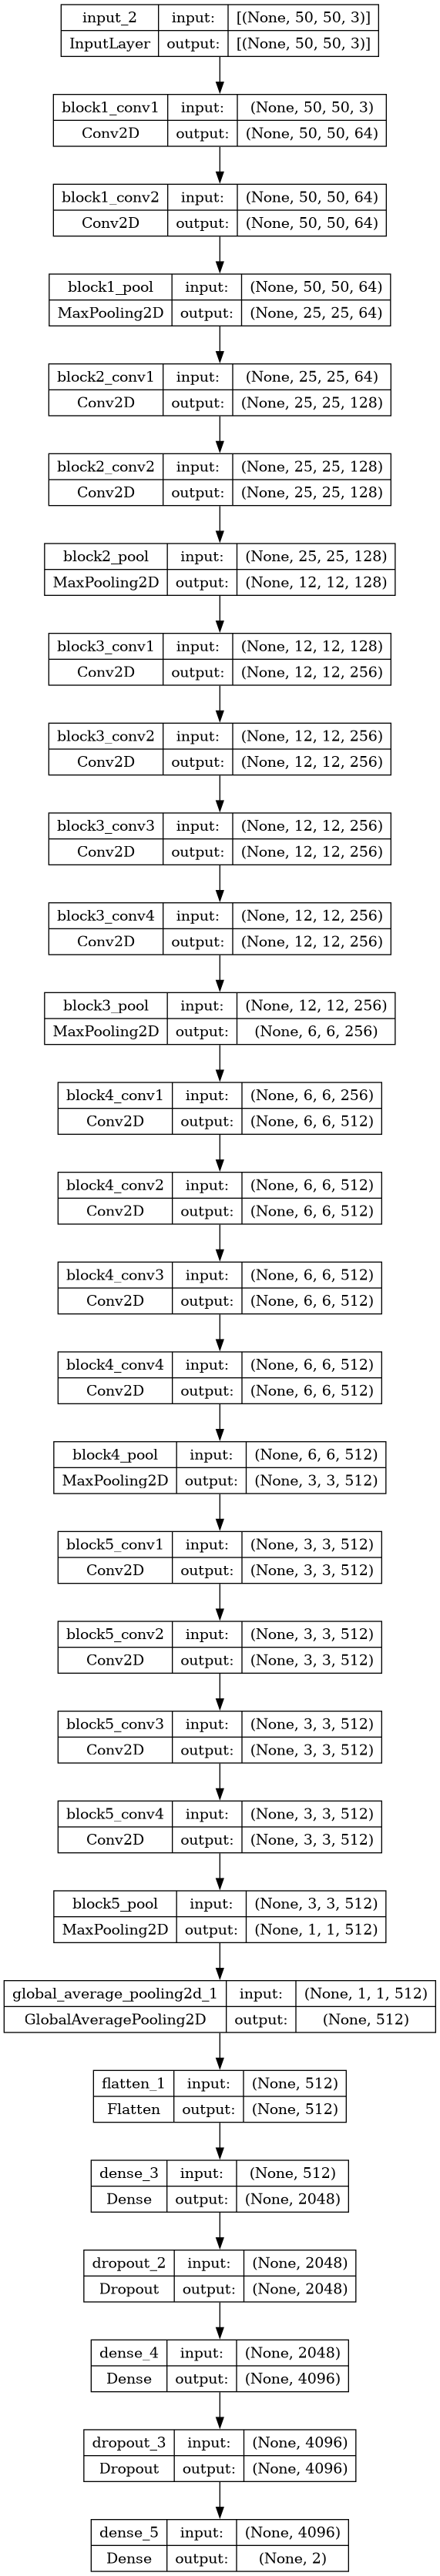

In [36]:
# Visualized Layers of CNN
keras.utils.plot_model(VGG19_model, show_shapes=True)

In [37]:
# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
VGG19_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
history_VGG19_model = VGG19_model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 50,
                    batch_size = 32,
                    callbacks=[plateau])

Epoch 1/50
250/250 [==============================] - 7s 23ms/step - loss: 1.6876 - accuracy: 0.7011 - val_loss: 0.7150 - val_accuracy: 0.7740 - lr: 1.0000e-04
Epoch 2/50
250/250 [==============================] - 6s 22ms/step - loss: 0.8738 - accuracy: 0.7462 - val_loss: 0.5698 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 3/50
250/250 [==============================] - 6s 22ms/step - loss: 0.6215 - accuracy: 0.7734 - val_loss: 0.4981 - val_accuracy: 0.7875 - lr: 1.0000e-04
Epoch 4/50
250/250 [==============================] - 6s 22ms/step - loss: 0.5078 - accuracy: 0.7926 - val_loss: 0.4655 - val_accuracy: 0.7935 - lr: 1.0000e-04
Epoch 5/50
250/250 [==============================] - 6s 22ms/step - loss: 0.4502 - accuracy: 0.8098 - val_loss: 0.4735 - val_accuracy: 0.7870 - lr: 1.0000e-04
Epoch 6/50
250/250 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.8284
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
250/250 [==================

In [ ]:
# Set a random seed for reproducibility
tf.random.set_seed(42)

# Create a Sequential model
model = tf.keras.Sequential([
    # Convolutional layer with 32 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 2x2 pool size and default stride (2)
    tf.keras.layers.MaxPooling2D(strides=2),
    
    # Convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Flatten the output to prepare for fully connected layers
    tf.keras.layers.Flatten(),
    
    # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # Output layer with 2 units (binary classification) and softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# Display a summary of the model architecture
model.summary()

In [ ]:
# Visualized Layers of CNN
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 25,
                    batch_size = 75,
                    callbacks=[early_stopping, plateau])